# Feature Selection

In [15]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.signal import savgol_filter
import statsmodels.api as sm
import pymc3 as pm
import statsmodels.api as sm
from statsmodels.tools import add_constant
from itertools import combinations
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(12,6)})

In [16]:
# Read in the data
df = pd.read_pickle('nfl_df_averages.pkl')

In [19]:
# create a table of all the columns in df and save it as a csv
df

,date,home,away,winner,score_home,score_away,score_diff,first_downs_opp_homeAvg,first_downs_homeAvg,third_downs_opp_homeAvg,...,penalties_yards_awayAvg,redzone_sucess_opp_awayAvg,redzone_rate_opp_awayAvg,redzone_attempts_opp_awayAvg,redzone_sucess_awayAvg,redzone_rate_awayAvg,redzone_attempts_awayAvg,season_awayAvg,home_awayAvg,day_number_awayAvg
0,2002-09-05,Giants,49ers,0,13,16,-3,13.000000,21.000000,4.000000,...,29.000000,0.000000,0.000000,6.000000,0.000000,0.000000,8.000000,2002.000000,N,0.000000
1,2002-09-08,Bills,Jets,0,31,37,-6,18.000000,26.000000,2.000000,...,90.000000,0.000000,0.000000,8.000000,0.000000,0.000000,9.000000,2002.000000,N,3.000000
2,2002-09-08,Bears,Vikings,1,27,23,4,19.000000,20.000000,5.000000,...,52.000000,0.000000,0.000000,6.000000,0.000000,0.000000,7.000000,2002.000000,N,3.000000
3,2002-09-08,Bengals,Chargers,0,6,34,-28,27.000000,13.000000,6.000000,...,39.000000,0.000000,0.000000,5.000000,0.000000,0.000000,7.000000,2002.000000,N,3.000000
4,2002-09-08,Browns,Chiefs,0,39,40,-1,24.000000,24.000000,5.000000,...,87.000000,0.000000,0.000000,10.000000,0.000000,0.000000,10.000000,2002.000000,N,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5352,2022-01-23,Buccaneers,Rams,0,27,30,-3,17.052305,20.002375,4.303757,...,30.867869,1.428049,0.477551,2.765151,2.049533,0.495423,3.426942,1713.093248,N,5938.081576
5353,2022-01-23,Chiefs,Bills,1,42,36,6,18.005949,20.765085,4.006287,...,47.359284,1.181489,0.398347,2.261554,2.414286,0.518320,3.846913,1718.755163,N,5958.709196
5354,2022-01-30,Chiefs,Bengals,0,24,27,-3,17.936891,20.929582,4.169578,...,32.421640,1.590045,0.508397,2.801089,1.564615,0.499617,2.807266,1731.405155,N,6008.891366
5355,2022-01-30,Rams,49ers,1,20,17,3,16.807587,17.334040,4.300598,...,52.313323,1.621259,0.523562,2.884804,1.740075,0.594537,2.686206,1733.086754,N,6015.832935


In [6]:
df.head()

,date,home,away,winner,score_home,score_away,score_diff,first_downs_opp_homeAvg,first_downs_homeAvg,third_downs_opp_homeAvg,...,penalties_yards_awayAvg,redzone_sucess_opp_awayAvg,redzone_rate_opp_awayAvg,redzone_attempts_opp_awayAvg,redzone_sucess_awayAvg,redzone_rate_awayAvg,redzone_attempts_awayAvg,season_awayAvg,home_awayAvg,day_number_awayAvg
0,2002-09-05,Giants,49ers,0,13,16,-3,13.0,21.0,4.0,...,29.0,0.0,0.0,6.0,0.0,0.0,8.0,2002.0,N,0.0
1,2002-09-08,Bills,Jets,0,31,37,-6,18.0,26.0,2.0,...,90.0,0.0,0.0,8.0,0.0,0.0,9.0,2002.0,N,3.0
2,2002-09-08,Bears,Vikings,1,27,23,4,19.0,20.0,5.0,...,52.0,0.0,0.0,6.0,0.0,0.0,7.0,2002.0,N,3.0
3,2002-09-08,Bengals,Chargers,0,6,34,-28,27.0,13.0,6.0,...,39.0,0.0,0.0,5.0,0.0,0.0,7.0,2002.0,N,3.0
4,2002-09-08,Browns,Chiefs,0,39,40,-1,24.0,24.0,5.0,...,87.0,0.0,0.0,10.0,0.0,0.0,10.0,2002.0,N,3.0


### PCA and Feature Selection

In [7]:
# Define Features
features = []
for col in df.columns:
    if 'Avg' in col:
        features.append(col)

# Convert the date column to a datetime object
df['date'] = pd.to_datetime(df['date'])

# convert home_homeAvg and home_awayAvg from "Y" / "N" to 1 / 0
df['home_homeAvg'] = df['home_homeAvg'].map({'Y': 1, 'N': 0})
df['home_awayAvg'] = df['home_awayAvg'].map({'Y': 1, 'N': 0})

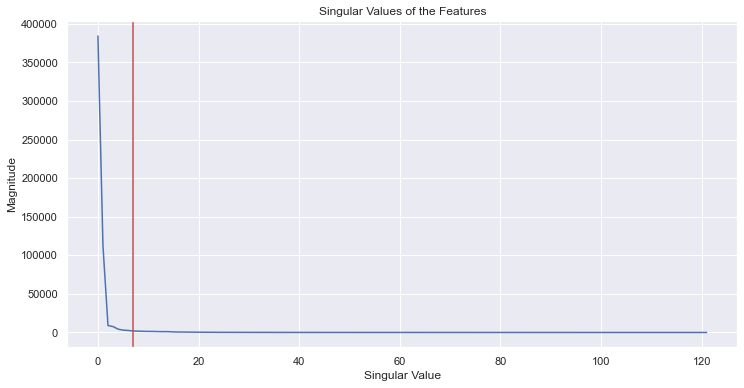

In [8]:
# Create a features dataframe
X = df[features]

# plot the svd of the features
U, s, V = np.linalg.svd(X, full_matrices=False)

# add labels to the plot
plt.plot(s)
plt.axvline(x=7, color='r')
plt.xlabel('Singular Value')
plt.ylabel('Magnitude')
plt.title('Singular Values of the Features')
plt.savefig('FeatureImportancePlots/SVs.jpg', dpi=1000)
plt.show()

In [9]:
# print the columns of the 7 most important features
print(X.columns[np.argsort(V[0])[-8:]])

# save only the 8 most important features in the features list
features = X.columns[np.argsort(V[0])[-8:]]

# remove home_awayAvg from the features list
features = features.drop('home_awayAvg')

# create a new dataframe with only the 7 most important features
X = df[features]

Index(['fourth_downs_rate_awayAvg', 'def_st_td_homeAvg', 'def_st_td_awayAvg',
       'def_st_td_opp_awayAvg', 'def_st_td_opp_homeAvg', 'score_diff_homeAvg',
       'score_diff_awayAvg', 'home_awayAvg'],
      dtype='object')


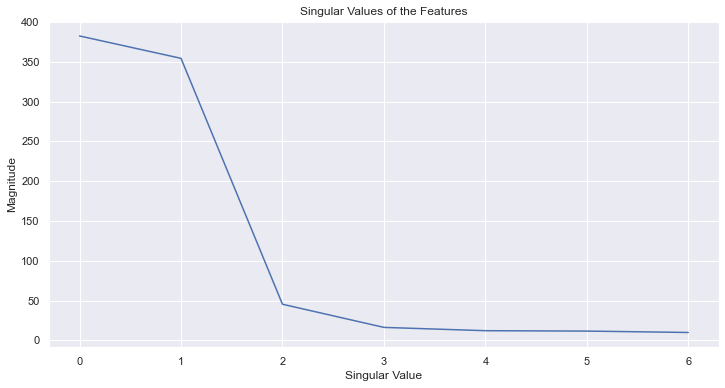

In [10]:
# perform SVD on the new dataframe
U, s, V = np.linalg.svd(X, full_matrices=False)

# plot the svd of the features
plt.plot(s)
plt.xlabel('Singular Value')
plt.ylabel('Magnitude')
plt.title('Singular Values of the Features')
plt.savefig('FeatureImportancePlots/SVsSparse.jpg', dpi=1000)
plt.show()

In [11]:
# generate a y variable that is the winner column from df
y = df['winner']


# create a sklearn logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

# fit the model
model.fit(X, y)

# evaluate the model
from sklearn.metrics import accuracy_score
y_pred = model.predict(X)
print(accuracy_score(y, y_pred))


0.6378570095202539


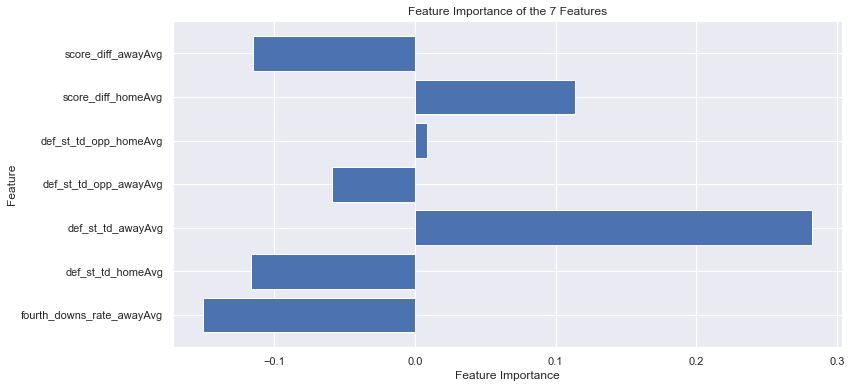

In [12]:
# plot the importance of 7 chosen features
plt.barh(X.columns, model.coef_[0])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the 7 Features')
plt.savefig('FeatureImportancePlots/FeatureImportanceSparse.jpg', dpi=1000)
plt.show()

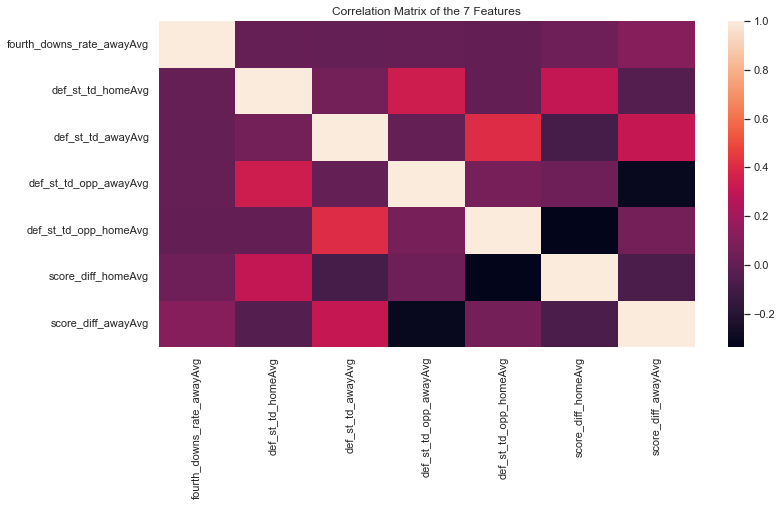

In [13]:
# create a correlation matrix
corr = X.corr()
# plot the correlation matrix
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# add a title
plt.title('Correlation Matrix of the 7 Features')
plt.savefig('FeatureImportancePlots/Correlation.jpg', dpi=1000)
plt.show()

### Save the df with only the feature and winner columns

In [14]:
# save the df with only the columns in feeatures and the winner column and include the date column
df = df[features.append(pd.Index(['home', 'away', 'winner', 'date']))]

# save the df to a csv and call it nfl_df_7features.csv
df.to_csv('nfl_df_7features.csv')